Time Series Forecasting Tool
Loaded 54 data points from 54 input years
Data range: 1970 to 2023
ADF Statistic: -0.5354
p-value: 0.8849
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (0, 1, 0)
AIC: 190.82

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   21.85        17.87        25.83       
2026   21.85        16.97        26.73       
2027   21.85        16.22        27.48       
2028   21.85        15.55        28.15       
2029   21.85        14.95        28.75       
2030   21.85        14.40        29.30       
2031   21.85        13.89        29.81       
2032   21.85        13.40        30.30       
2033   21.85        12.95        30.75       
2034   nan          nan          nan         


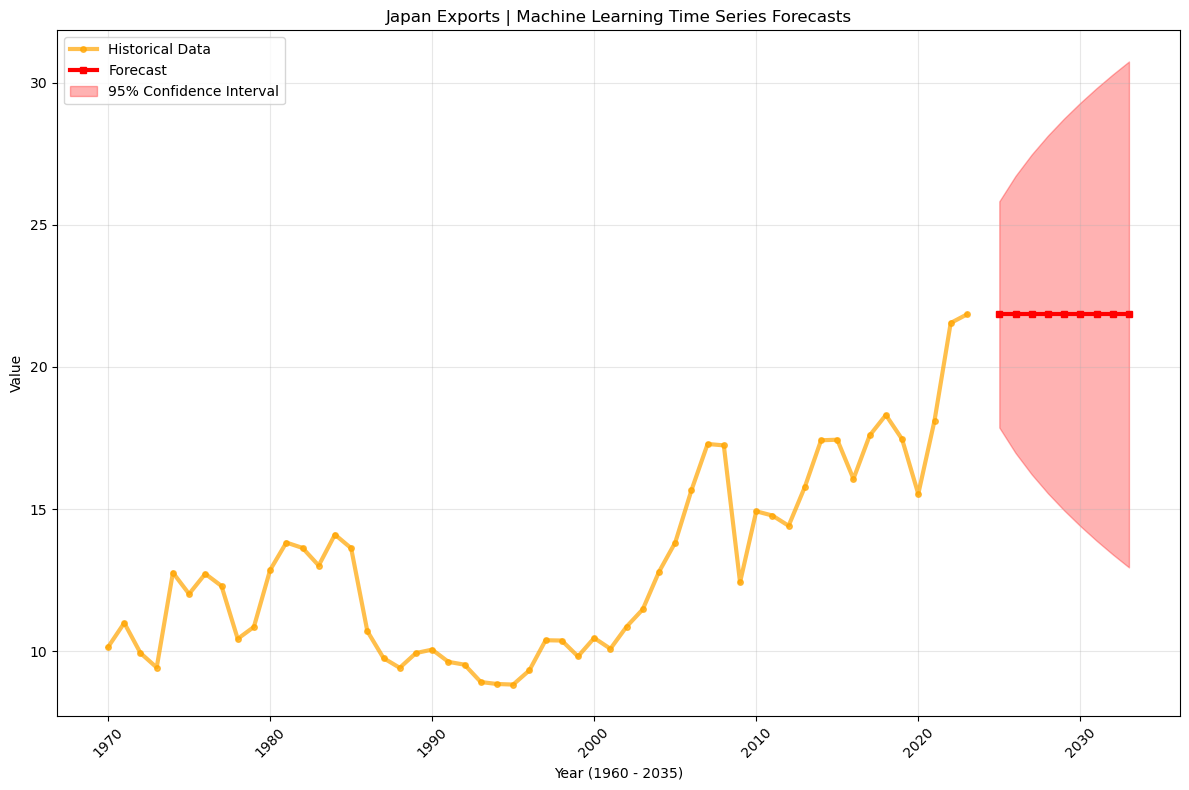

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -94.410
Date:                Sat, 26 Jul 2025   AIC                            190.821
Time:                        00:33:57   BIC                            192.791
Sample:                    01-01-1970   HQIC                           191.578
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.0643      0.296      6.969      0.000       1.484       2.645
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.93
Prob(Q):                              0.99   Pr

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Japan Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: JAPAN EXPORTS
    sample_data = {
        1970:10.14,1971:10.99,1972:9.93,1973:9.42,1974:12.76,
        1975:12.01,1976:12.72,1977:12.29,1978:10.43,1979:10.85,
        1980:12.85,1981:13.82,1982:13.63,1983:13.01,1984:14.10,
        1985:13.62,1986:10.70,1987:9.75,1988:9.41,1989:9.93,
        1990:10.05,1991:9.62,1992:9.52,1993:8.91,1994:8.84,
        1995:8.82,1996:9.32,1997:10.38,1998:10.37,1999:9.81,
        2000:10.46,2001:10.08,2002:10.86,2003:11.47,2004:12.79,
        2005:13.82,2006:15.66,2007:17.29,2008:17.24,2009:12.42,
        2010:14.92,2011:14.77,2012:14.41,2013:15.78,2014:17.42,
        2015:17.44,2016:16.06,2017:17.59,2018:18.31,2019:17.46,
        2020:15.53,2021:18.11,2022:21.55,2023:21.85
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Time Series Forecasting Tool
Loaded 54 data points from 54 input years
Data range: 1970 to 2023
ADF Statistic: -0.2033
p-value: 0.9381
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (0, 1, 2)
AIC: 216.43

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   21.45        16.33        26.58       
2026   21.45        15.78        27.12       
2027   21.45        15.28        27.62       
2028   21.45        14.82        28.09       
2029   21.45        14.39        28.52       
2030   21.45        13.98        28.92       
2031   21.45        13.60        29.31       
2032   21.45        13.23        29.68       
2033   21.45        12.88        30.03       
2034   nan          nan          nan         


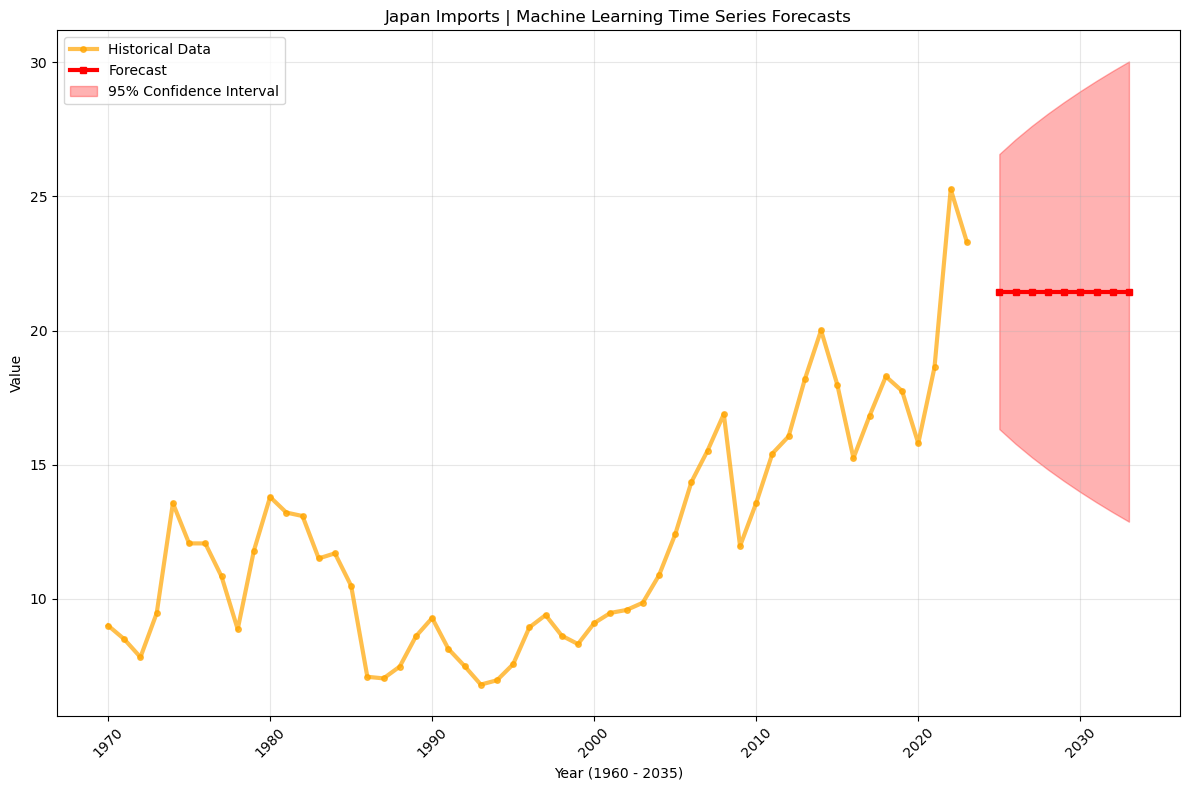

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -105.217
Date:                Sat, 26 Jul 2025   AIC                            216.434
Time:                        00:34:21   BIC                            222.345
Sample:                    01-01-1970   HQIC                           218.707
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1036      0.102      1.016      0.310      -0.096       0.304
ma.L2         -0.3973      0.138     -2.885      0.004      -0.667      -0.127
sigma2         3.0818      0.519      5.937      0.0

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Japan Imports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: JAPAN IMPORTS
    sample_data = {
        1970:9.01,1971:8.50,1972:7.83,1973:9.47,1974:13.57,
        1975:12.07,1976:12.07,1977:10.84,1978:8.87,1979:11.80,
        1980:13.80,1981:13.22,1982:13.09,1983:11.51,1984:11.70,
        1985:10.49,1986:7.10,1987:7.04,1988:7.48,1989:8.61,
        1990:9.29,1991:8.14,1992:7.50,1993:6.81,1994:6.97,
        1995:7.57,1996:8.94,1997:9.40,1998:8.63,1999:8.32,
        2000:9.10,2001:9.48,2002:9.59,2003:9.86,2004:10.88,
        2005:12.41,2006:14.36,2007:15.53,2008:16.89,2009:11.97,
        2010:13.58,2011:15.42,2012:16.06,2013:18.19,2014:20.01,
        2015:17.99,2016:15.25,2017:16.83,2018:18.29,2019:17.75,
        2020:15.80,2021:18.63,2022:25.27,2023:23.30
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Time Series Forecasting Tool
Loaded 64 data points from 65 input years
Data range: 1960 to 2023
ADF Statistic: -2.7298
p-value: 0.0690
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (2, 1, 3)
AIC: 297.87

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   1.84         -4.31        7.99        
2026   2.24         -4.28        8.76        
2027   1.98         -4.92        8.88        
2028   2.04         -5.58        9.66        
2029   2.11         -5.80        10.03       
2030   2.00         -6.38        10.39       
2031   2.08         -6.73        10.89       
2032   2.06         -7.08        11.20       
2033   2.04         -7.51        11.59       
2034   nan          nan          nan         


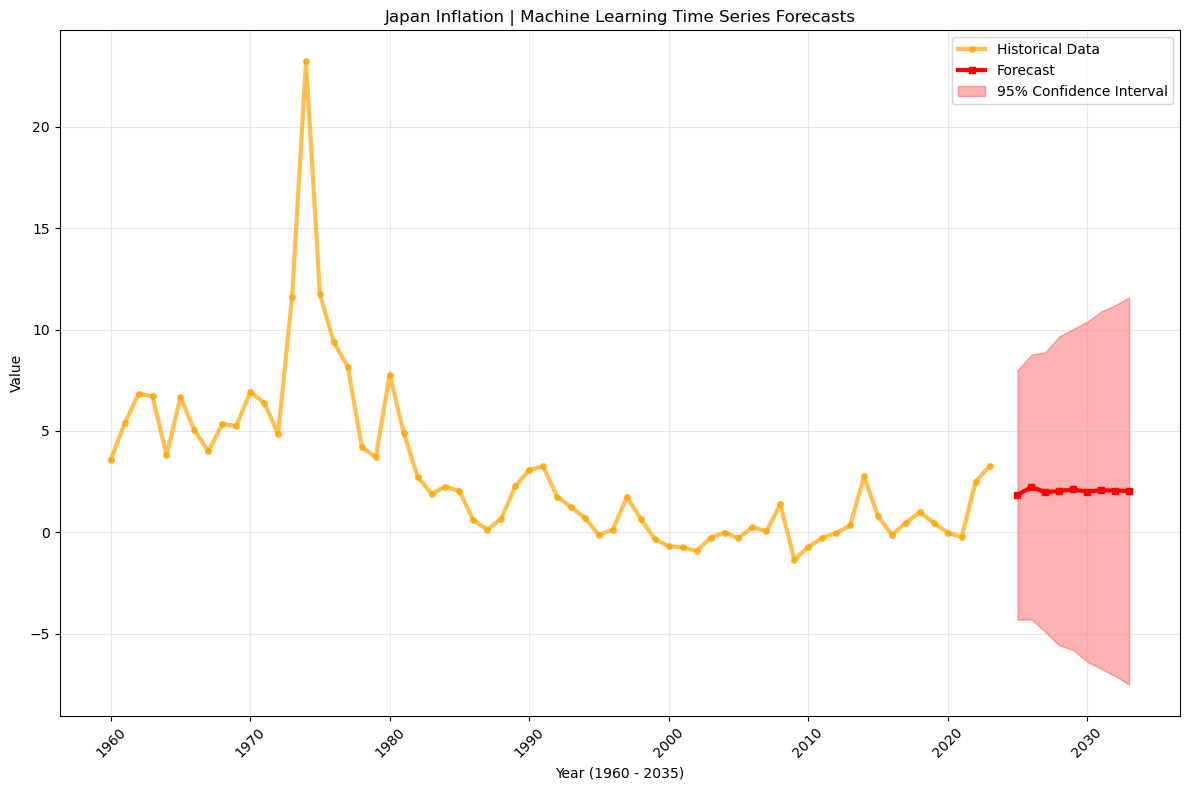

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -142.934
Date:                Sat, 26 Jul 2025   AIC                            297.867
Time:                        00:34:33   BIC                            310.726
Sample:                    01-01-1960   HQIC                           302.925
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0635      0.288     -3.694      0.000      -1.628      -0.499
ar.L2         -0.5382      0.288     -1.871      0.061      -1.102       0.025
ma.L1          0.9788      0.306      3.194      0.0

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Japan Inflation | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: JAPAN INFLATION
    sample_data = {
    1960:3.57,1961:5.37,1962:6.84,1963:6.71,1964:3.80,
    1965:6.66,1966:5.04,1967:3.99,1968:5.34,1969:5.25,
    1970:6.92,1971:6.40,1972:4.84,1973:11.61,1974:23.22,
    1975:11.73,1976:9.37,1977:8.16,1978:4.21,1979:3.70,
    1980:7.78,1981:4.91,1982:2.74,1983:1.90,1984:2.26,
    1985:2.03,1986:0.60,1987:0.13,1988:0.68,1989:2.27,
    1990:3.08,1991:3.25,1992:1.76,1993:1.24,1994:0.70,
    1995:-0.13,1996:0.14,1997:1.75,1998:0.66,1999:-0.34,
    2000:-0.68,2001:-0.74,2002:-0.92,2003:-0.26,2004:-0.01,
    2005:-0.28,2006:0.25,2007:0.06,2008:1.38,2009:-1.35,
    2010:-0.73,2011:-0.27,2012:-0.04,2013:0.34,2014:2.76,
    2015:0.80,2016:-0.13,2017:0.48,2018:0.99,2019:0.47,
    2020:-0.02,2021:-0.23,2022:2.50,2023:3.27,2024:2.74
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()